# Table of content

1. [Introduction](#Introduction)
2. [Data overview](#Data-overview)
3. [Data wrangling](#Data-wrangling)
4. [Factor analysis](#Factor-analysis)
    1. [Factor interpretation](#Factor-interpretation)
5. [Exploratory analysis](#Exploratory-analysis) 
    1. [Box-Cox power transformation](#Box-Cox-power-transformation)
    2. [Linearity and normality](#Linearity-and-normality)
6. [Multiple linear regression](#Multiple-linear-regression)
    1. [Model interpretation](#Model-interpretation)
7. [Final remarks](#Final-remarks)


# Introduction

For this analysis, my research question would be what factors are associated with COVID-19 infection rates in the United States counties. I would be utilizing various datasets concerning county health information, county COVID-19 infection rates, county population densities, and state political affiliation. In turn, I would attempt to identify and evaluate risk factors connected to infection rates by doing multiple regression analysis. The resultant linear regression model would be used mainly for interpretation. The outcome of the study could be used to better understand a population's vulnerability to COVID-19 based on the community's characteristics from the reference point of the American counties.  

In [134]:
# Kaggle specific code

# !pip install factor_analyzer

# https://www.kaggle.com/general/63534#672910
# !pip install altair vega_datasets notebook vega # needs internet in settings (right panel)

# https://www.kaggle.com/jakevdp/altair-kaggle-renderer
# Define and register a kaggle renderer for Altair

import json
import altair as alt
from IPython.display import HTML

KAGGLE_HTML_TEMPLATE = """
<style>
.vega-actions a {{
    margin-right: 12px;
    color: #757575;
    font-weight: normal;
    font-size: 13px;
}}
.error {{
    color: red;
}}
</style>
<div id="{output_div}"></div>
<script>
requirejs.config({{
    "paths": {{
        "vega": "{base_url}/vega@{vega_version}?noext",
        "vega-lib": "{base_url}/vega-lib?noext",
        "vega-lite": "{base_url}/vega-lite@{vegalite_version}?noext",
        "vega-embed": "{base_url}/vega-embed@{vegaembed_version}?noext",
    }}
}});
function showError(el, error){{
    el.innerHTML = ('<div class="error">'
                    + '<p>JavaScript Error: ' + error.message + '</p>'
                    + "<p>This usually means there's a typo in your chart specification. "
                    + "See the javascript console for the full traceback.</p>"
                    + '</div>');
    throw error;
}}
require(["vega-embed"], function(vegaEmbed) {{
    const spec = {spec};
    const embed_opt = {embed_opt};
    const el = document.getElementById('{output_div}');
    vegaEmbed("#{output_div}", spec, embed_opt)
      .catch(error => showError(el, error));
}});
</script>
"""

class KaggleHtml(object):
    def __init__(self, base_url='https://cdn.jsdelivr.net/npm'):
        self.chart_count = 0
        self.base_url = base_url
        
    @property
    def output_div(self):
        return "vega-chart-{}".format(self.chart_count)
        
    def __call__(self, spec, embed_options=None, json_kwds=None):
        # we need to increment the div, because all charts live in the same document
        self.chart_count += 1
        embed_options = embed_options or {}
        json_kwds = json_kwds or {}
        html = KAGGLE_HTML_TEMPLATE.format(
            spec=json.dumps(spec, **json_kwds),
            embed_opt=json.dumps(embed_options),
            output_div=self.output_div,
            base_url=self.base_url,
            vega_version=alt.VEGA_VERSION,
            vegalite_version=alt.VEGALITE_VERSION,
            vegaembed_version=alt.VEGAEMBED_VERSION
        )
        return {"text/html": html}
    
alt.renderers.register('kaggle', KaggleHtml())
print("Define and register the kaggle renderer. Enable with\n\n"
      "    alt.renderers.enable('kaggle')")

# alt.renderers.enable('kaggle')

Define and register the kaggle renderer. Enable with

    alt.renderers.enable('kaggle')


In [135]:
# Import necessary libraries 

import pandas as pd
import numpy as np 
import altair as alt
import statsmodels.formula.api as smf
import statsmodels.api as sm  
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo
from scipy import stats
import itertools
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
from scipy.stats import levene, normaltest

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Data overview

Let's take a look at the datasets this analysis will be using. A few of them  are put together by crawling wiki pages. The rest are from what are provided officially.

In [136]:
# https://github.com/nytimes/covid-19-data
# Cumulative counts of coronavirus cases in the US at the county level
county_infection = pd.read_csv('relevant_data/us-counties.csv')

In [137]:
county_infection.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [138]:
# let's sort the counties first by date

county_infection['date'] = pd.to_datetime(county_infection['date'])
county_infection = county_infection.sort_values(by='date')

In [139]:
county_infection.tail()

,date,county,state,fips,cases,deaths
139458,2020-05-13,Graves,Kentucky,21083.0,149,18
139459,2020-05-13,Grayson,Kentucky,21085.0,99,6
139460,2020-05-13,Green,Kentucky,21087.0,1,0
139462,2020-05-13,Hancock,Kentucky,21091.0,6,0
141402,2020-05-13,Washakie,Wyoming,56043.0,7,0


> The latest date of the data is May 13th, 2020.

In [140]:
county_infection[(county_infection['state'] == 'Illinois') & (county_infection['county'] == 'Cook')]

,date,county,state,fips,cases,deaths
3,2020-01-24,Cook,Illinois,17031.0,1,0
6,2020-01-25,Cook,Illinois,17031.0,1,0
11,2020-01-26,Cook,Illinois,17031.0,1,0
16,2020-01-27,Cook,Illinois,17031.0,1,0
21,2020-01-28,Cook,Illinois,17031.0,1,0
...,...,...,...,...,...,...
127415,2020-05-09,Cook,Illinois,17031.0,51674,2264
130328,2020-05-10,Cook,Illinois,17031.0,52655,2317
133240,2020-05-11,Cook,Illinois,17031.0,53381,2361
136151,2020-05-12,Cook,Illinois,17031.0,55470,2449


In [141]:
county_infection[(county_infection['state'] == 'California') & (county_infection['county'] == 'Santa Clara')]

,date,county,state,fips,cases,deaths
36,2020-01-31,Santa Clara,California,6085.0,1,0
42,2020-02-01,Santa Clara,California,6085.0,1,0
50,2020-02-02,Santa Clara,California,6085.0,2,0
58,2020-02-03,Santa Clara,California,6085.0,2,0
66,2020-02-04,Santa Clara,California,6085.0,2,0
...,...,...,...,...,...,...
127045,2020-05-09,Santa Clara,California,6085.0,2307,131
129957,2020-05-10,Santa Clara,California,6085.0,2339,131
132869,2020-05-11,Santa Clara,California,6085.0,2341,131
135780,2020-05-12,Santa Clara,California,6085.0,2364,134


> It seems like each county's data starts with the first case of infection and then contains each subsequent day's cumulative count.

In [142]:
# https://en.wikipedia.org/wiki/County_(United_States)
# County population and density
county_population = pd.read_csv('relevant_data/county-population.csv')

In [143]:
county_population.head()

,state,county,population,land_area_km,density_km
0,Alabama,Autauga,54571,1540,35.436
1,Alabama,Baldwin,182265,4118,44.261
2,Alabama,Barbour,27457,2292,11.979
3,Alabama,Bibb,22915,1612,14.215
4,Alabama,Blount,57322,1670,34.325


In [144]:
# https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states
# https://en.wikipedia.org/wiki/List_of_United_States_governors
# State party affiliation based on house representation
state_party_line = pd.read_csv('relevant_data/state_party_line.csv')

In [145]:
state_party_line.head()

,state,state_house_blue_perc,state_governor_party
0,Alabama,22.86,red
1,Alaska,35.00,red
2,Arizona,43.33,red
3,Arkansas,25.71,red
4,California,72.50,blue


In [146]:
# Source: https://www.countyhealthrankings.org/
# Access: https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774?organizationId=5ea77ea08fb3bf000c9879a1
# County health information
county_health = pd.read_csv('relevant_data/us-county-health-rankings-2020.csv')

In [147]:
county_health.head()

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
0,1000,Alabama,NaN,81791.0,9942.794666,9840.535949,10045.053384,NaN,NaN,NaN,...,4.443264,3197324,65.413428,48517,1.061048,1.006759,1.115337,51.633032,1957932.0,40.963183
1,1001,Alabama,Autauga,791.0,8128.591190,7283.340731,8973.841649,1.0,NaN,NaN,...,2.965774,41316,74.308016,426,0.820225,0.347891,1.292558,51.448715,22921.0,42.002162
2,1003,Alabama,Baldwin,2967.0,7354.122530,6918.554269,7789.690790,1.0,NaN,NaN,...,4.646779,181201,83.111337,1068,0.543517,0.347271,0.739763,51.538377,77060.0,42.279099
3,1005,Alabama,Barbour,472.0,10253.573403,8782.217281,11724.929524,2.0,NaN,NaN,...,4.276355,11356,45.641252,398,1.631683,0.824903,2.438462,47.216752,18613.0,67.789635
4,1007,Alabama,Bibb,471.0,11977.539484,10344.064842,13611.014126,3.0,NaN,NaN,...,2.625000,16708,74.589286,57,0.268210,0.000000,0.807504,46.781250,15663.0,68.352607


In [148]:
county_health.columns[:75]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> This dataset contains extensive information about a county's attributes, including the rankings, quantiles, rates, and percentages of numerous demographic as well as health qualities. Of the many measurements of each quality, we probably only need one or two to avoid duplication. In addition, I will do a **factor analysis** on the columns to see if it makes sense.

For more information about these columns, please visit this [info](https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774/info?organizationId=5ea77ea08fb3bf000c9879a1) page

# Data wrangling

In this section, we want to prepare our data for further exploration and analysis. 

In [149]:
# Aggregate data related to county infection and basic characteristics
county = county_infection.merge(
    county_population, left_on=['county', 'state'], right_on=['county', 'state']
).merge(
    state_party_line, left_on=['state'], right_on=['state']
)

In [150]:
county.sample(5)

,date,county,state,fips,cases,deaths,population,land_area_km,density_km,state_house_blue_perc,state_governor_party
64249,2020-04-02,Cherokee,Oklahoma,40021.0,7,0,46987,1945,24.158,18.75,red
41033,2020-04-20,Moore,North Carolina,37125.0,67,0,94191,1829,51.499,42.00,blue
31452,2020-04-20,Rockingham,New Hampshire,33015.0,489,11,301777,1800,167.654,58.33,red
89868,2020-05-03,Sherman,Kansas,20181.0,5,0,6113,2735,2.235,27.50,blue
20739,2020-03-27,Navarro,Texas,48349.0,1,0,48701,2774,17.556,38.71,red


Let's look at the statistics of the counted days for the counties

In [151]:
# Count the number of days each county data has
def count_days(series):
    time_series = pd.to_datetime(series)
    first_date = time_series.iloc[0]
    last_date = time_series.iloc[-1]
    
    return (last_date - first_date).days + 1

In [152]:
grouped_county = county.groupby(['state', 'county']).agg(days_counted=('date', count_days))

In [153]:
grouped_county.describe()

,days_counted
count,2758.000000
mean,48.719362
std,12.420495
min,1.000000
25%,43.000000
50%,50.000000
75%,56.000000
max,114.000000


In [154]:
grouped_county.shape

(2758, 1)

> We have 2758 counties in the data. The minimum amount of days counted for a county is only one, while the maximum is about almost four months. I am happy that the median is 50 days. Ideally, I want all counties in the analysis to have at least two months worth of data so that any of its heath characteristics can have a decent chance of exerting its influence if there could be any at all. With the current data and analysis, I will only include counties with 50 day worth of data to maximize the representativeness of the eventual infection picture and not exclude too much data. Please understand that I'm not a domain expert. I apologize that this cutoff point seems rather arbitrary, but I hope the rationale makes sense domain-wise.

With that said, for the next step, we want to group the infection data by counties and create a bunch of aggregated columns including counted days, confirmed infection in the percentage of county population, death rate, and raw infection counts. We will also calculate those columns for the cutoff point of 50 days so that we can do the analysis without accounting for the number of days for model simplicity. This is also where we will exclude counties that have less than 50 days of data.

In [155]:
# Find the value at the 50 day mark
def county_cumulative_days(series, days = 50):
    # This may not be 100% accurate because perhaps some days are missing, 
    # but that seems to happen rarely. So this should be accurate enough.
    if len(series) < days:
        return series.iloc[-1]
    else:
        return series.iloc[days - 1]

In [156]:
# Group our data in terms of county and aggregate some columns to show overall infection rate 
# and death rate as well as at the 50 day mark
def group_county_data(data):
    grouped_data = data.groupby(['state', 'county']).agg(
        population=('population', lambda x: x.iloc[-1]),
        density_km=('density_km', lambda x: x.iloc[-1]),
        state_house_blue_perc=('state_house_blue_perc', lambda x: x.iloc[-1]),
        state_governor_party=('state_governor_party', lambda x: x.iloc[-1]),
        days_counted=('date', count_days),
        case_sum=('cases', lambda x: x.iloc[-1]),
        death_sum=('deaths', lambda x: x.iloc[-1]),
        case_count_50_days=('cases', county_cumulative_days),
        death_count_50_days=('deaths', county_cumulative_days)
    )
    
    grouped_data = grouped_data[grouped_data['days_counted'] >= 50]
    grouped_data['infection_rate'] = grouped_data['case_sum']/grouped_data['population']*100
    grouped_data['death_rate'] = grouped_data['death_sum']/grouped_data['case_sum']*100
    grouped_data = grouped_data[grouped_data['infection_rate'] != float("inf")]
    grouped_data['infection_rate_50_days'] = grouped_data['case_count_50_days']/grouped_data['population']*100
    grouped_data['death_rate_50_days'] = grouped_data['death_count_50_days']/grouped_data['case_count_50_days']*100
    
    return grouped_data.reset_index()

In [157]:
grouped_county = group_county_data(county)

In [158]:
grouped_county

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,death_count_50_days,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,91,4,0.170420,4.301075,0.166755,4.395604
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,181,4,0.126739,3.030303,0.099306,2.209945
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,45,0,0.078504,0.000000,0.078504,0.000000
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,230,6,1.098009,2.608696,1.098009,2.608696
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,114,3,0.107108,2.362205,0.096144,2.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,0,0.061052,0.000000,0.061052,0.000000
1459,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,0,0.003484,0.000000,0.003484,0.000000
1460,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,0,0.054061,0.000000,0.054061,0.000000
1461,Wyoming,Sweetwater,45267,1.676,10.00,red,51,20,0,20,0,0.044182,0.000000,0.044182,0.000000


> We end up with 1463 counties.

In [159]:
grouped_county.sample(5)

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,death_count_50_days,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days
265,Georgia,Gordon,55766,60.681,37.50,red,62,124,16,113,12,0.222358,12.903226,0.202632,10.619469
314,Georgia,Turner,8410,11.350,37.50,red,55,80,12,74,12,0.951249,15.000000,0.879905,16.216216
655,Michigan,Van Buren,76258,27.013,42.11,blue,50,94,4,94,4,0.123266,4.255319,0.123266,4.255319
508,Kentucky,McCracken,65316,100.486,23.68,blue,51,73,2,73,2,0.111764,2.739726,0.111764,2.739726
124,California,Santa Cruz,276864,239.709,72.50,blue,68,146,2,115,2,0.052733,1.369863,0.041537,1.739130


Next, let's tackle county health data.

In [160]:
# Remove state total rows first
county_health = county_health.dropna(subset=['county'])

Take a quick look over the data again.

In [161]:
county_health.sample(5)

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
2447,46089,South Dakota,McPherson,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,1.371001,2323,96.510179,2,0.090580,0.000000,2.020423,50.477773,2459.0,100.000000
2173,40011,Oklahoma,Blaine,202.0,12897.992624,10228.783804,15567.201445,4.0,NaN,NaN,...,11.396943,6825,71.955720,370,4.074441,2.549177,5.599705,50.764365,6859.0,57.431131
1352,27029,Minnesota,Clearwater,129.0,8071.645309,5720.241993,10423.048624,4.0,NaN,NaN,...,2.372304,7428,84.313280,40,0.483676,0.000000,1.139013,48.876277,8695.0,100.000000
2694,48255,Texas,Karnes,189.0,7144.314343,5716.626845,8572.001841,1.0,NaN,NaN,...,55.309904,5502,35.156550,957,6.584107,3.851110,9.317104,41.156550,5691.0,38.390448
106,4013,Arizona,Maricopa,43437.0,6474.453729,6387.803942,6561.103516,1.0,12924.391392,12054.401223,...,31.278441,2421633,54.902055,204723,5.150585,NaN,NaN,50.537179,90229.0,2.363800


In [162]:
county_health.columns

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low',
       ...
       'percent_hispanic', 'num_non_hispanic_white',
       'percent_non_hispanic_white', 'num_not_proficient_in_english',
       'percent_not_proficient_in_english', '95percent_ci_low_39',
       '95percent_ci_high_39', 'percent_female', 'num_rural', 'percent_rural'],
      dtype='object', length=507)

In [163]:
county_health.columns[:100]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> There are 507 columns. To reiterate my proposed course of action, we want to first get rid of many different measurements of the same quality and only keep the rates. We also want to remove some redundant columns such as population. The purpose is to hopefully keep the complexity under a managable level, while maintaining the values of the information.

In [164]:
excluded_column_words = [
    'quartile',
    'ci_high',
    'ci_low',
    'fips',
    'num',
    'denominator',
    'ratio',
    'population',
]

In [165]:
filtered_columns = county_health.columns[~county_health.columns.str.contains('|'.join(excluded_column_words))]

In [166]:
print(str(len(filtered_columns)) + ' columns remain!')

190 columns remain!


In [167]:
filtered_county_health = county_health[filtered_columns]

Next, let's merge the health data into the infection data, and check out the merged data.

In [168]:
county = grouped_county.merge(
    filtered_county_health, left_on=['county', 'state'], right_on=['county', 'state']
)

In [169]:
county

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,91,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,181,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,45,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,230,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,114,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775
1460,Wyoming,Sweetwater,45267,1.676,10.00,red,51,20,0,20,...,12.111217,1.145153,1.544680,1.010429,0.157952,16.083250,79.312908,1.633221,48.544749,10.916313


> We still have a lot of columns. Perhaps a lot of them have missing data for more than half of the data. We have no reasonable and accessible way of dealing with missing data here. We could fill in missing values from nearby counties, but that could be both erroneous and difficult. As a result, we will simply get rid of missing data in terms of columns and rows. Let's deal with columns first because we want to keep as many as rows as possible.

In [170]:
# Let's see the columns at near 90% cutoff points
county.dropna(thresh=1300, axis=1).info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1461
Data columns (total 91 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   state                                               1462 non-null   object 
 1   county                                              1462 non-null   object 
 2   population                                          1462 non-null   int64  
 3   density_km                                          1462 non-null   float64
 4   state_house_blue_perc                               1462 non-null   float64
 5   state_governor_party                                1462 non-null   object 
 6   days_counted                                        1462 non-null   int64  
 7   case_sum                                            1462 non-null   int64  
 8   death_sum                                           1462 non-null   int64  
 9

> At the 90% row number cutoff point, we have a decent amount of columns. Most of the columns seem important, so we will try to keep most of them by setting the cutoff point at 1370 rows to keep the indexes related to suicide.

In [171]:
county.dropna(thresh=1370, axis=1).dropna()

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,91,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,181,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,45,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,230,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,114,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Wyoming,Laramie,94483,13.581,10.00,red,58,173,1,162,...,16.028128,2.417758,1.169981,1.365988,0.134376,14.795506,78.501859,0.823311,49.310944,19.784604
1457,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775


We are keeping a good amount of data. Let's go ahead with that decision.

In [172]:
county = county.dropna(thresh=1370, axis=1).dropna()

# Factor analysis

After data wrangling, we are still dealing with a large number of columns. If we continue with our anaylsis as is, it might suffer from the curse of dimensionality. Also, if we are to include interaction terms, the number of parameters could get close to the number of rows. Furthermore, there is a high chance that we will run into multicollinearity. For all these reaons, I have decided to run factor anaylsis as the next step to reduce dimensionality and find independant latent variables. Please refer to its [wiki](https://en.wikipedia.org/wiki/Factor_analysis) for more information on the technique itself.

In [173]:
# Exclude columns that won't be used as explanatory variables and can't used in factor analysis
excluded_columns = [
    'state',
    'county', 
    'population',
    'state_house_blue_perc',
    'state_governor_party',
    'days_counted', 
    'case_sum', 
    'death_sum', 
    'case_count_50_days',
    'death_count_50_days', 
    'infection_rate', 
    'death_rate',
    'infection_rate_50_days', 
    'death_rate_50_days',
    'presence_of_water_violation'
]

In [174]:
county_non_factor = county[excluded_columns]

In [175]:
county_factor = county.drop(excluded_columns, axis=1)

In [176]:
len(county_factor.columns)

72

In [177]:
county_factor.columns

Index(['density_km', 'years_of_potential_life_lost_rate',
       'percent_fair_or_poor_health', 'percent_low_birthweight',
       'percent_smokers', 'percent_adults_with_obesity',
       'food_environment_index', 'percent_physically_inactive',
       'percent_with_access_to_exercise_opportunities',
       'percent_excessive_drinking',
       'percent_driving_deaths_with_alcohol_involvement', 'chlamydia_rate',
       'teen_birth_rate', 'percent_uninsured', 'primary_care_physicians_rate',
       'dentist_rate', 'mental_health_provider_rate',
       'preventable_hospitalization_rate', 'percent_with_annual_mammogram',
       'percent_vaccinated', 'high_school_graduation_rate',
       'percent_some_college', 'labor_force', 'percent_unemployed',
       'percent_children_in_poverty', 'percent_children_in_poverty_white',
       '80th_percentile_income', '20th_percentile_income',
       'percent_single_parent_households', 'social_association_rate',
       'annual_average_violent_crimes', 'viole

Let's check whether factor anaylsis is appropriate first. We will be using [Levene’s test](https://en.wikipedia.org/wiki/Levene%27s_test) and [Kaiser-Meyer-Olkin Test](https://www.statisticshowto.com/kaiser-meyer-olkin/). The former is used to access whether or not the variables have homoscedasticity for samples that might not have perfectly normal distributions. The latter measures the suitability of data for factor analysis.

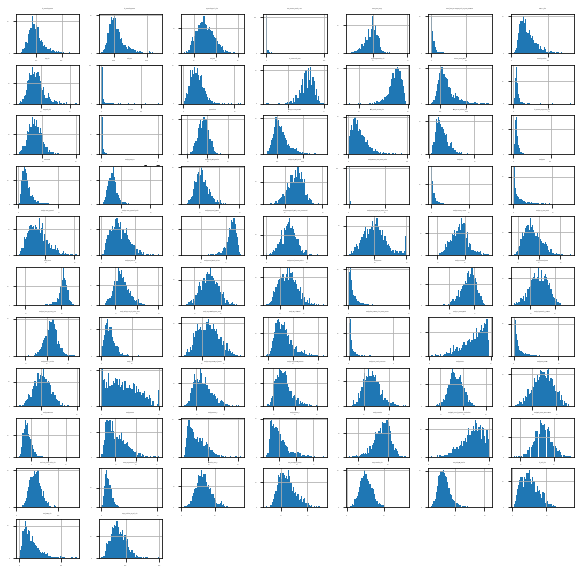

In [179]:
# To access which function of the data to use in the Levene test, 
# we need to access the normality of the columns
fig = county_factor.hist(
    column=county_factor.columns, 
    xlabelsize=0.1, 
    ylabelsize=0.1, 
    layout=(11, 7), 
    figsize=(10, 10),
    bins=50
)  
[x.title.set_size(0) for x in fig.ravel()]
plt.show()

> Seems like most columns have tailed distributions. Only a few have non-normal distributions. As a result, we will look at the test results for both `mean` and `trimmed` functions. I do acknowledge that there seems to be no perfect test to account for the variety of distributions here.

In [184]:
levene(*county_factor.to_numpy(), center='trimmed')

LeveneResult(statistic=1.1387295321326967, pvalue=0.0005807421210454923)

In [185]:
levene(*county_factor.to_numpy(), center='mean')

LeveneResult(statistic=3.168856325919061, pvalue=1.3216449271368782e-260)

> The tests were both statistically significant, indicating that there is likely no homoscedasticity among the variables. 

In [186]:
kmo_all, kmo_model = calculate_kmo(county_factor)

In [187]:
kmo_model

0.8819606142503196

> This score indicates that the data is excellent for factor analysis.

Let's check out all the original eigenvalues first.

In [188]:
fa = FactorAnalyzer()

# Using the varimax rotation because it makes it easier to identify each variable with a single factor.
fa.set_params(rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [189]:
ev, v = fa.get_eigenvalues()
ev[:30]

array([21.09925431,  9.73527455,  5.3048947 ,  4.8617724 ,  2.63753264,
        2.22663958,  2.10510852,  1.83063723,  1.52004831,  1.37137097,
        1.34273314,  1.20113302,  1.04581375,  0.99119531,  0.8781521 ,
        0.84633963,  0.76192877,  0.68487218,  0.65687675,  0.62533965,
        0.58695729,  0.54843543,  0.52788423,  0.47962377,  0.46479846,
        0.44304009,  0.43492847,  0.41749941,  0.38875819,  0.3858833 ])

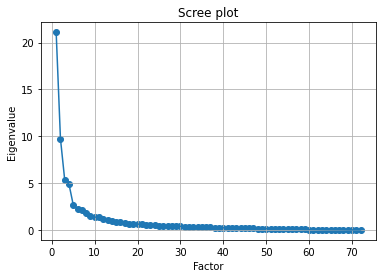

In [190]:
plt.scatter(range(1, len(ev)+1), ev)
plt.plot(range(1, len(ev)+1), ev)
plt.title('Scree plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

> It seems like we have 14 factors that are significant (eigenvalue >= 1)..

In [191]:
fa = FactorAnalyzer()
fa.set_params(n_factors=14, rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=14, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [192]:
factor_loading = pd.DataFrame(fa.loadings_)

In [193]:
factor_loading.index = county_factor.columns

In [194]:
factor_loading.shape

(72, 14)

In [195]:
factor_loading

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
density_km,-0.119234,0.187374,0.072004,0.154731,-0.009790,0.068612,0.038734,0.263607,0.111428,0.010794,0.648083,-0.047954,0.149837,0.061192
years_of_potential_life_lost_rate,0.906348,-0.064934,-0.117186,-0.212227,0.064410,-0.011658,0.006598,-0.021829,0.153219,0.122915,-0.032401,0.087594,0.042471,0.029847
percent_fair_or_poor_health,0.862020,0.095747,0.291806,0.085937,0.186143,-0.040967,0.085899,-0.038728,0.014875,0.045635,-0.041272,-0.067616,0.023098,-0.111811
percent_low_birthweight,0.687871,0.107777,-0.103498,0.133266,0.154809,0.048563,0.058828,0.020077,0.245803,-0.166429,0.068010,0.276673,0.060026,-0.164823
percent_smokers,0.813178,-0.086899,-0.238013,-0.056079,-0.067489,-0.051242,0.113120,-0.073763,-0.103471,0.075243,-0.041671,-0.097181,0.111917,-0.025176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
percent_hispanic,-0.101587,0.145303,0.851322,0.050122,0.267681,-0.030124,0.032682,0.089338,-0.065097,0.002348,-0.018229,0.038451,0.123382,0.014074
percent_non_hispanic_white,-0.277738,-0.285742,-0.546551,-0.291974,-0.292665,-0.033392,-0.197012,-0.137811,-0.251177,-0.071783,-0.152323,-0.373088,-0.061916,0.173255
percent_not_proficient_in_english,-0.103257,0.207816,0.821404,0.222650,0.203931,0.008811,0.013834,0.157426,-0.040213,0.039530,0.138056,-0.021421,0.109000,0.106196
percent_female,0.149313,0.138805,-0.141272,0.186123,0.060534,0.267489,-0.031786,0.109113,0.362329,-0.027057,-0.104050,0.050198,0.146823,0.108633


## Factor interpretation

Now that we have collected all the significant factors, let's interpret them one by one. We will look at columns that have decent loadings(>|.3|) for easier interpretations.

In [196]:
def filter_decent_loadings(factor):
    return factor[(factor > 0.3) | (factor < -0.3)]

In [197]:
for factor in factor_loading.columns:
    print('Factor ' + str(factor + 1) + ' loadings: ')
    print()
    print(filter_decent_loadings(factor_loading[factor]))
    print()
    print()

Factor 1 loadings: 

years_of_potential_life_lost_rate                0.906348
percent_fair_or_poor_health                      0.862020
percent_low_birthweight                          0.687871
percent_smokers                                  0.813178
percent_adults_with_obesity                      0.670328
food_environment_index                          -0.690546
percent_physically_inactive                      0.771663
percent_with_access_to_exercise_opportunities   -0.534604
percent_excessive_drinking                      -0.593774
chlamydia_rate                                   0.475192
teen_birth_rate                                  0.783371
percent_uninsured                                0.340279
primary_care_physicians_rate                    -0.324238
dentist_rate                                    -0.354391
preventable_hospitalization_rate                 0.567072
percent_with_annual_mammogram                   -0.348581
percent_vaccinated                              -0.

1. The first factor seems to encompass a lot of indexes related to general well-being. Some of its most substantial positive loadings(> .8) are for the years of potential life lost rate, the percentage of fair or poor health, the percentage of smokers, the percentage of physical or mental distress, and child poverty percentage. Some of its most substantial negative loadings(< -.7) are for median household income, life expectancy, general income, and college percentage. It explains a lot of variables connected to welfare in high coefficients. And its positive direction is towards poor welfare. Based on the loadings, I can identify this factor as **poor general well-being** with decent confidence.

2. The second factor has apparent connections to variables related to housing issues. Its biggest loadings(> .8) are for the percentage of severe housing problems, severe housing cost burden, and the percentage of severe housing cost burden. The percentage of homeowners has the lowest loadings for this factor. It is convincing that this factor is for **housing burden**.

3. The third factor seems to be connected to the prevalence of hispanic population. Its most substantial positive loadings(> 0.8) are for the percentage of hispanic population and the percentage of people not proficient in English. Its most vigorous negative factor loading is for the percentage of non-hispanic white population(~-.52). Other variables, such as housing problems and youth population, with lower factor loadings also seem to make sense for hispanic population prevalence. As a result, I would determine this factor to be **hispanic relative population size**.  

4. The fourth factor is mostly about suicide rates in the opposite direction, so we could interpret this to be **inverse suicide rate**.

5. The fifth factor is for **uninsured rate** because that's all its concerns with high loadings.

6. The sixth factor has mostly to do with care provider rates such as dentist and mental health(> .5). It seems to be inversely connected with rural percentage and long commute. Although its loadings are relatively weaker, we can probably conclude that it is for **care provider accessibility**.

7. The seventh factor seems to be about the population age as the extreme youth percentage has a positive loading(> .55), and the senior percentage has a very negative loading(< -.86). We can somewhat conclude that this factor is for **population youth**.

8. The eighth factor seems to be mostly about the crime rate and its contributing factors, so we will determine this as **crime risk**.

9. The ninth factor should have weak loadings overall. The theme seems to be about the overall income as it includes median household income, 80th & 20th percentile income, long commute, and white household income. We will loosely define this factor to be about **overall income level**.

10. The tenth factor seems to be highly related to population density. Its highest loadings are for density in km(\~.66), traffic volumn(\~.4), and Asian population(\~.48), while its lowest loadings are related to lone drive to work. It is clear that this factor is about **population density level**.

11. The ninth factor should be somewhat apparent, with its two biggest loadings being the percentage of American Indian Alaska Native(.75) and inadequate kitchen or plumbing facilities(.71). We will determine this factor to be about **native relative population size**.

12. The twelveth factor seems to be mainly connected to black population. Its most significant loading is for the percentage of black population(~.44). A lot of its other loadings are seemingly problems more common in black communities. Some examples are low high school graduation rate, crime rate, and single parent households. One of its negative loadings is the percentage of non-hispanic white population. I think we can determine that this factor is for **black relative population size**.

13. The thirteenth factor seems to be about urbanization with its most negative loading being about rural percentage and its most positive one about access to exercise opportunities. The [latter](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/county-health-rankings-model/health-factors/health-behaviors/diet-exercise/access-to-exercise-opportunities) is defined to be specifically about facilities, which are more plentiful in an urban environment. As a result, we will determine this factor to be about **urbanization level**.

14. The fourteenth factor is also straightforward as its loadings are all about food. We will determine it to be about **poor food environment index** due to its related variables and their directions.

> Please note that these interpreations are purely subjective and could be done better with more domain knowledge.

In [198]:
fa.get_factor_variance()

(array([19.40860486,  4.61517973,  4.5694364 ,  3.46736403,  3.34189506,
         3.25659406,  2.32454872,  2.31368341,  2.1623178 ,  1.99091846,
         1.88265745,  1.65725221,  1.42116413,  1.18206233]),
 array([0.26956396, 0.06409972, 0.06346439, 0.04815783, 0.04641521,
        0.04523047, 0.0322854 , 0.03213449, 0.03003219, 0.02765165,
        0.02614802, 0.02301739, 0.01973839, 0.01641753]),
 array([0.26956396, 0.33366367, 0.39712807, 0.4452859 , 0.49170111,
        0.53693159, 0.56921698, 0.60135148, 0.63138367, 0.65903531,
        0.68518333, 0.70820072, 0.72793912, 0.74435665]))

> Together the 14 factors explain about 74% of the total variance.

Now with the factors interpreted, let's transform the original columns into factor scores, and append `_fa_score` to the factor names. Then, we will merge the data back.

In [199]:
fa_score_columns = [
    'poor_general_wellbeing_fa_score',
    'housing_burden_fa_score',
    'hispanic_relative_population_fa_score',
    'inverse_sucicde_rate_fa_score',
    'uninsured_rate_fa_score',
    'care_provider_accessibility_fa_score',
    'population_youth_fa_score',
    'crime_risk_fa_score',
    'overall_income_fa_score',
    'population_density_fa_score',
    'native_relative_population_fa_score',
    'black_relative_population_fa_score',
    'urbanization_level_fa_score',
    'poor_food_environment_fa_score',
]

transformed_county_factor = pd.DataFrame(
    fa.transform(county_factor),
    columns=fa_score_columns
)

In [200]:
county = county_non_factor.reset_index(drop=True).join(transformed_county_factor)

# Exploratory analysis

In this section, we want to explore some factors' distribution and their relationships with the response variable. We will also compare the counties by their state governor parties. For the rest of the analysis, we will set the response variable as the infection rate at 50 days since the first case of a county.

In [201]:
# Remove some columns we are interested in for sure
county = county.drop(columns=[
    'population', 
    'state_house_blue_perc', 
    'days_counted',
    'case_sum',
    'death_sum',
    'case_count_50_days',
    'death_count_50_days'
])

In [202]:
county.sample(5)

,state,county,state_governor_party,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days,presence_of_water_violation,poor_general_wellbeing_fa_score,housing_burden_fa_score,...,uninsured_rate_fa_score,care_provider_accessibility_fa_score,population_youth_fa_score,crime_risk_fa_score,overall_income_fa_score,population_density_fa_score,native_relative_population_fa_score,black_relative_population_fa_score,urbanization_level_fa_score,poor_food_environment_fa_score
1112,Virginia,Prince Edward,blue,0.300627,2.898551,0.213489,4.081633,f,0.562096,-0.105930,...,-0.203668,-0.222510,-0.038174,-0.241462,-0.453284,0.887824,0.680279,0.503376,-1.388854,-1.474458
648,New Jersey,Camden,blue,1.005565,4.824475,0.542323,3.854545,f,0.370402,1.426006,...,-0.147272,0.583715,-0.139524,0.012446,1.633250,-0.205274,1.220678,-0.575105,1.426816,3.026450
359,Iowa,Buchanan,red,0.114515,0.000000,0.109743,0.000000,f,-0.727582,-1.019311,...,0.719702,-0.896970,-0.223277,0.182016,-1.081024,-0.181543,0.423239,0.110729,-0.397812,2.243240
259,Georgia,Polk,red,0.167525,0.000000,0.101971,0.000000,f,0.999858,0.179009,...,0.667535,-0.953091,0.549796,-0.112275,-0.808579,1.329502,-0.900638,-0.511304,1.026736,-2.538859
630,Nevada,Clark,blue,0.228894,5.450942,0.150358,4.918527,t,0.136717,0.282847,...,-0.763271,-0.560443,0.823495,5.416511,-0.792016,-0.749876,0.255033,0.488127,0.021282,0.008729


In [203]:
county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   state                                  1208 non-null   object 
 1   county                                 1208 non-null   object 
 2   state_governor_party                   1208 non-null   object 
 3   infection_rate                         1208 non-null   float64
 4   death_rate                             1208 non-null   float64
 5   infection_rate_50_days                 1208 non-null   float64
 6   death_rate_50_days                     1208 non-null   float64
 7   presence_of_water_violation            1208 non-null   object 
 8   poor_general_wellbeing_fa_score        1208 non-null   float64
 9   housing_burden_fa_score                1208 non-null   float64
 10  hispanic_relative_population_fa_score  1208 non-null   float64
 11  inve

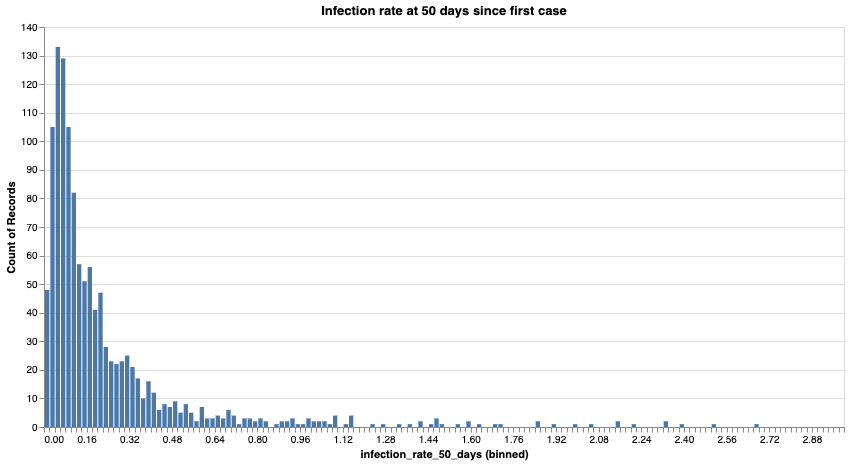

In [204]:
alt.Chart(county).mark_bar().encode(
    alt.X("infection_rate_50_days", bin=alt.Bin(extent=[0, 3], step=0.02)),
    y='count()',
).properties(
    width=800,
    height=400,
    title='Infection rate at 50 days since first case'
)

> It looks like we might have a right skewness for the response variable distribution. Alternatively and maybe more accurately, we are looking at a gamma distribution here.  Most counties' infection rates seem to lie below 0.8.

## Box-Cox power transformation

In any case, we will fix the skewness and achieve a normal distribution by transforming the response variable as opposed to building a generalized linear model with gamma distribution for easier interpretation and better intuition, from my perspective. We will use the [Box-Cox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) power transformation because it tends to be more powerful than log transformation and taking the root in solving skewness.

In [206]:
infection_rate_50_days_boxcox, lmbda = stats.boxcox(county['infection_rate_50_days'])

In [207]:
lmbda

0.0442749827010597

Let the transformed rate be `x` and the old rate be `y`. 

The formula of their relationship is `(lmbda * x + 1)^(1/lambda) = y`, which in this case is approximately `(0.044x + 1)^22.73 = y`. Let's visualize what that means.

In [208]:
county['infection_rate_50_days_boxcox'] = infection_rate_50_days_boxcox

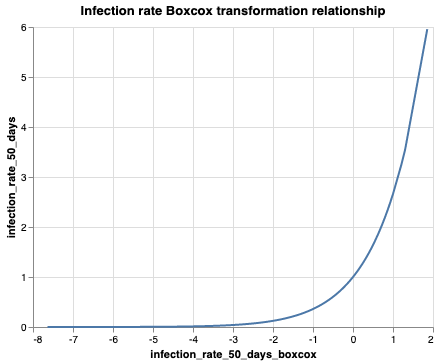

In [209]:
alt.Chart(county).mark_line().encode(
    x='infection_rate_50_days_boxcox',
    y='infection_rate_50_days'
).properties(
    title='Infection rate Boxcox transformation relationship'
)

> Basically, as the Box-Cox transformed infection rate increase, the real infection rate increases exponentially, meaning the coefficients have exponential impacts on the real infection rate.

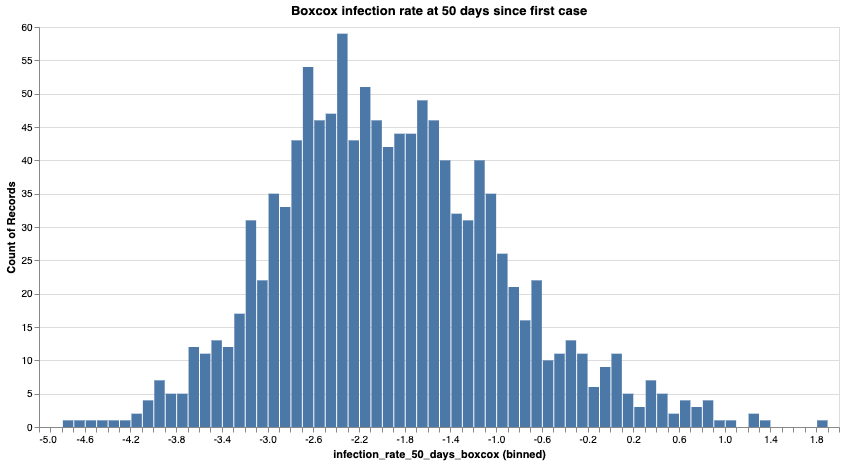

In [210]:
alt.Chart(county).mark_bar().encode(
    alt.X("infection_rate_50_days_boxcox", bin=alt.Bin(extent=[-5, 2], step=0.1)),
    y='count()',
).properties(
    width=800,
    height=400,
    title='Boxcox infection rate at 50 days since first case'
)

> The new response variable's distribution looks a lot more normal.

Next, let's look at the correlatons with the transformed rate.

In [211]:
county[county['state_governor_party'] == 'blue'].corr(method='pearson')['infection_rate_50_days_boxcox']

infection_rate                           0.743907
death_rate                               0.151545
infection_rate_50_days                   0.782449
death_rate_50_days                       0.133529
poor_general_wellbeing_fa_score          0.108636
housing_burden_fa_score                  0.073384
hispanic_relative_population_fa_score   -0.014886
inverse_sucicde_rate_fa_score            0.300721
uninsured_rate_fa_score                  0.012795
care_provider_accessibility_fa_score    -0.112099
population_youth_fa_score                0.057019
crime_risk_fa_score                     -0.206564
overall_income_fa_score                  0.301382
population_density_fa_score             -0.049376
native_relative_population_fa_score      0.086806
black_relative_population_fa_score       0.010903
urbanization_level_fa_score              0.262078
poor_food_environment_fa_score           0.021172
infection_rate_50_days_boxcox            1.000000
Name: infection_rate_50_days_boxcox, dtype: float6

> For a county in a blue state, the more prominent positively correlated factors(>.25) are **urbanization**, **income level**, and **inverse suicide**. The more prominent negatively correlated factors are **crime**(-.2) and **care provider accessibility**(-.1).

In [212]:
county[county['state_governor_party'] == 'red'].corr(method='pearson')['infection_rate_50_days_boxcox']

infection_rate                           0.694040
death_rate                               0.128459
infection_rate_50_days                   0.686071
death_rate_50_days                       0.097661
poor_general_wellbeing_fa_score          0.137039
housing_burden_fa_score                  0.118837
hispanic_relative_population_fa_score   -0.093204
inverse_sucicde_rate_fa_score            0.293189
uninsured_rate_fa_score                 -0.039009
care_provider_accessibility_fa_score    -0.046426
population_youth_fa_score                0.032956
crime_risk_fa_score                     -0.124158
overall_income_fa_score                  0.166027
population_density_fa_score             -0.044785
native_relative_population_fa_score      0.103346
black_relative_population_fa_score       0.212568
urbanization_level_fa_score              0.031064
poor_food_environment_fa_score           0.048332
infection_rate_50_days_boxcox            1.000000
Name: infection_rate_50_days_boxcox, dtype: float6

> For a county in a red state, the more prominent positively correlated factors(>.2) are **black population** and **inverse suicide**. The more prominent negatively correlated factors are **crime**(-.13) and **hispanic population**(-.11).

In [213]:
county.corr(method='pearson')['infection_rate_50_days_boxcox']

infection_rate                           0.721495
death_rate                               0.143224
infection_rate_50_days                   0.737318
death_rate_50_days                       0.119681
poor_general_wellbeing_fa_score          0.112480
housing_burden_fa_score                  0.095254
hispanic_relative_population_fa_score   -0.049398
inverse_sucicde_rate_fa_score            0.297276
uninsured_rate_fa_score                 -0.019177
care_provider_accessibility_fa_score    -0.084528
population_youth_fa_score                0.041186
crime_risk_fa_score                     -0.176432
overall_income_fa_score                  0.236033
population_density_fa_score             -0.043599
native_relative_population_fa_score      0.092618
black_relative_population_fa_score       0.110529
urbanization_level_fa_score              0.152172
poor_food_environment_fa_score           0.033841
infection_rate_50_days_boxcox            1.000000
Name: infection_rate_50_days_boxcox, dtype: float6

> Overall, the more prominent positively correlated factors(>.2) are **income level** and **inverse suicide**. The more prominent negatively correlated factors are **crime**(-.18) and **care provider accessibility**(-.085).

## Linearity and normality

Next, we will explore some of the more prominent explanatory variables and visualize their relationships with the infection rate as well as their distributions. We will look at common relatively significant and positively correlated explanatory variables first.

In [214]:
alt_y = alt.Y(
    'infection_rate_50_days_boxcox', 
    axis=alt.Axis(values=list(np.linspace(-6, 2, 81))),
    scale=alt.Scale(domain=(-5, 2), clamp=True)
)

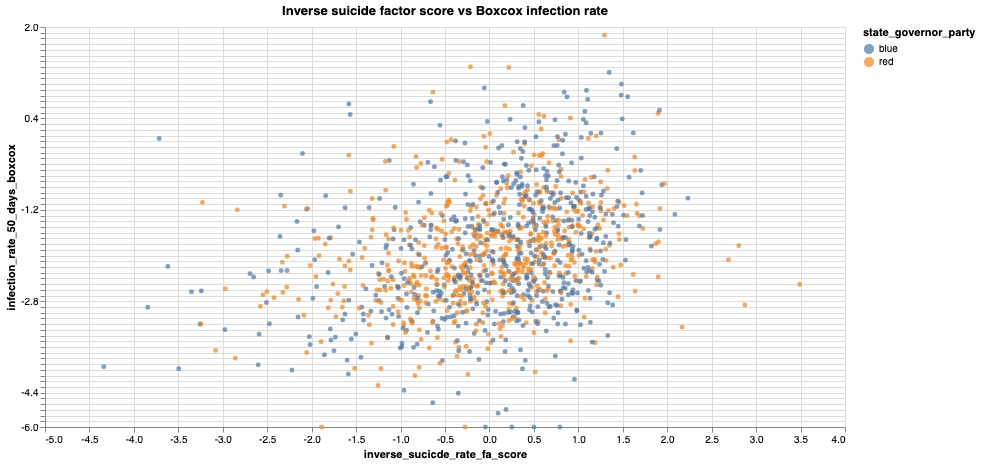

In [215]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='inverse_sucicde_rate_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Inverse suicide factor score vs Boxcox infection rate'
)

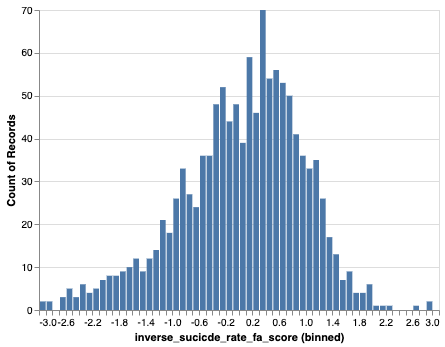

In [216]:
alt.Chart(county).mark_bar().encode(
    alt.X("inverse_sucicde_rate_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

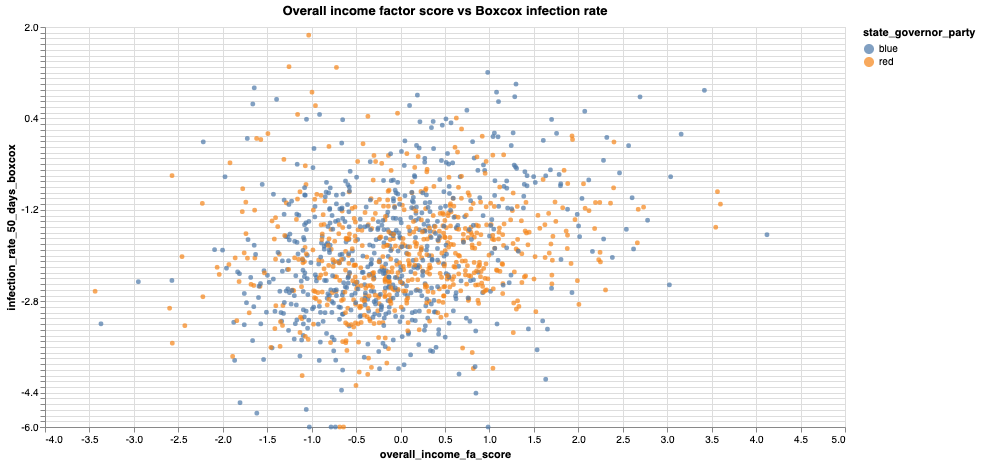

In [217]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='overall_income_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Overall income factor score vs Boxcox infection rate'
)

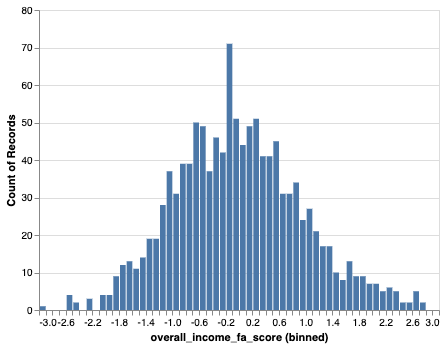

In [218]:
alt.Chart(county).mark_bar().encode(
    alt.X("overall_income_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

> As expected, though normally distributed, the above factor scores, with relatively high positive coefficients regardless of state party, have weak positive linearity relationships with the transformed infection rate.

We will look at some positively correlated explanatory variables that are relatively significant only to one party next.

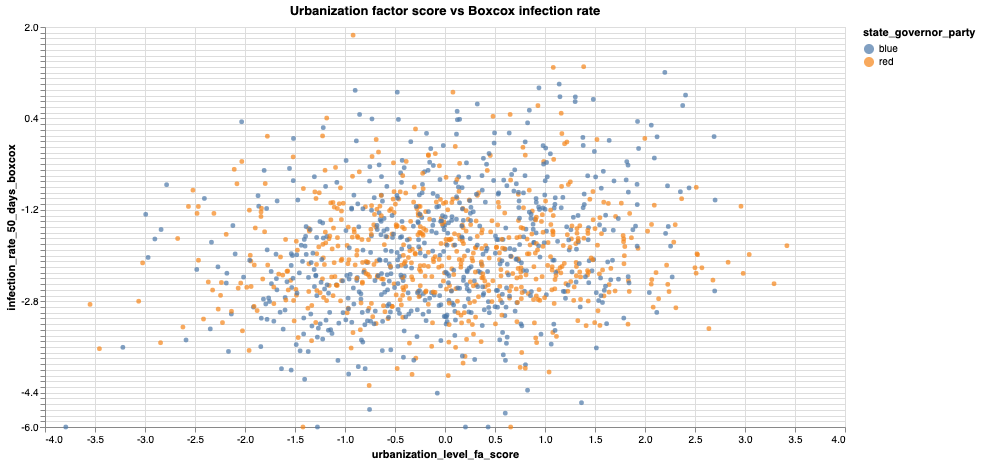

In [219]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='urbanization_level_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Urbanization factor score vs Boxcox infection rate'
)

> Blue counties exhibit stronger linearity here.

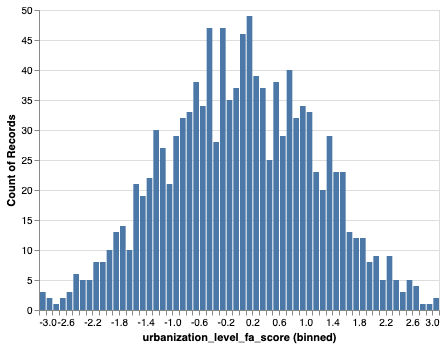

In [220]:
alt.Chart(county).mark_bar().encode(
    alt.X("urbanization_level_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

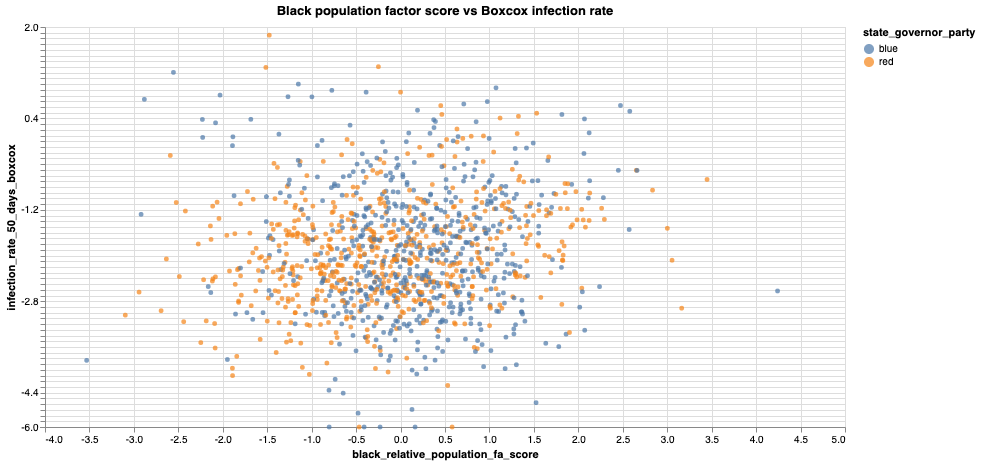

In [221]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='black_relative_population_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Black population factor score vs Boxcox infection rate'
)

> Red counties exhibit slightly stronger linearity here.

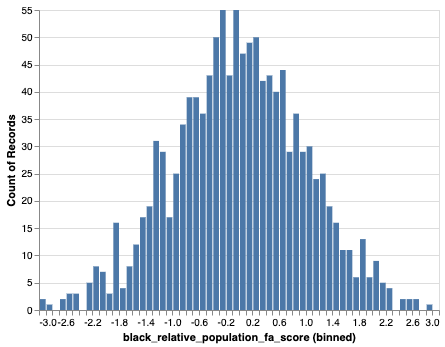

In [222]:
alt.Chart(county).mark_bar().encode(
    alt.X("black_relative_population_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

> Here we are looking at two factors that have different effects on counties in states with different governor parties. The urbanization factor has a pretty obvious but weak linearity relationship with the transformed infection rate in blue counties, but that relationship cannot be found with red counties. On the other hand, the black population factor has a very weak linearity relationship with the transformed infection rate only for counties in red states. Overall, these relationships are difficult to spot because they are not especially strong.

In conclusion, although linearity seems to be weak, it does exist for some explanatary variables with the response variable so that we can be confident on finding a somewhat useful linear equation. We can be fairly assured that decent normality is ensured and multicollinearity is alleviated with the factors. Moreover, based on the relationship graphs, we see no obvious pattern with the residuals, so we can be somewhat confident with homoscedasticity as well. With that said, we can proceed with the regression.

# Multiple linear regression

First, We will devise all combinations of model formulas and build them. Then, we will identify and explore the models with the highest adjusted R-squared, lowest AIC, and BIC scores. Finally, we will evaluate assumptions again and interpret the models.

In [223]:
interaction_term = 'state_governor_party'
response_variable = 'infection_rate_50_days_boxcox'
explanatory_variables = fa_score_columns

In [224]:
explanatory_variables

['poor_general_wellbeing_fa_score',
 'housing_burden_fa_score',
 'hispanic_relative_population_fa_score',
 'inverse_sucicde_rate_fa_score',
 'uninsured_rate_fa_score',
 'care_provider_accessibility_fa_score',
 'population_youth_fa_score',
 'crime_risk_fa_score',
 'overall_income_fa_score',
 'population_density_fa_score',
 'native_relative_population_fa_score',
 'black_relative_population_fa_score',
 'urbanization_level_fa_score',
 'poor_food_environment_fa_score']

In [225]:
variable_combinations = []

for variable in explanatory_variables:
    variable_combinations.append([variable, variable + '*' + interaction_term])

In [226]:
formula_combinations = list(itertools.product(*variable_combinations))

In [227]:
print('There are ' + str(len(formula_combinations)) + ' combinations.')

There are 16384 combinations.


In [228]:
models = []
rsquared_adjs = []
formulas = []
aics = []
bics = []

for combo in formula_combinations:
    explanatory_variable_part = ' + '.join(combo)
    formula = ' '.join([
        'infection_rate_50_days_boxcox ~',
        explanatory_variable_part
    ])
    
    mod = smf.ols(formula=formula, data=county)
    res = mod.fit()

    models.append(res)
    formulas.append(formula)
    rsquared_adjs.append(res.rsquared_adj)
    aics.append(res.aic)
    bics.append(res.bic)
    
    if len(models)%1600 == 0:
        print(str(len(models)) + ' models finished so far!')

1600 models finished so far!
3200 models finished so far!
4800 models finished so far!
6400 models finished so far!
8000 models finished so far!
9600 models finished so far!
11200 models finished so far!
12800 models finished so far!
14400 models finished so far!
16000 models finished so far!


In [229]:
result = pd.DataFrame({
    'formula': formulas,
    'rsquared_adj': rsquared_adjs,
    'aic': aics,
    'bic': bics,
    'model': models
})

In [230]:
result.sort_values(by='rsquared_adj', ascending=False).head()

,formula,rsquared_adj,aic,bic,model
14514,infection_rate_50_days_boxcox ~ poor_general_w...,0.291640,3120.290510,3237.515102,<statsmodels.regression.linear_model.Regressio...
15538,infection_rate_50_days_boxcox ~ poor_general_w...,0.291518,3121.478177,3243.799490,<statsmodels.regression.linear_model.Regressio...
14522,infection_rate_50_days_boxcox ~ poor_general_w...,0.291443,3121.605926,3243.927239,<statsmodels.regression.linear_model.Regressio...
14578,infection_rate_50_days_boxcox ~ poor_general_w...,0.291441,3121.609956,3243.931270,<statsmodels.regression.linear_model.Regressio...
15602,infection_rate_50_days_boxcox ~ poor_general_w...,0.291325,3122.785728,3250.203762,<statsmodels.regression.linear_model.Regressio...


In [231]:
result.sort_values(by='aic').head()

,formula,rsquared_adj,aic,bic,model
14514,infection_rate_50_days_boxcox ~ poor_general_w...,0.291640,3120.290510,3237.515102,<statsmodels.regression.linear_model.Regressio...
10418,infection_rate_50_days_boxcox ~ poor_general_w...,0.290517,3121.222360,3233.350231,<statsmodels.regression.linear_model.Regressio...
12466,infection_rate_50_days_boxcox ~ poor_general_w...,0.290495,3121.259278,3233.387148,<statsmodels.regression.linear_model.Regressio...
15538,infection_rate_50_days_boxcox ~ poor_general_w...,0.291518,3121.478177,3243.799490,<statsmodels.regression.linear_model.Regressio...
14522,infection_rate_50_days_boxcox ~ poor_general_w...,0.291443,3121.605926,3243.927239,<statsmodels.regression.linear_model.Regressio...


In [232]:
result.sort_values(by='bic').head()

,formula,rsquared_adj,aic,bic,model
34,infection_rate_50_days_boxcox ~ poor_general_w...,0.283521,3129.143037,3220.884021,<statsmodels.regression.linear_model.Regressio...
50,infection_rate_50_days_boxcox ~ poor_general_w...,0.286317,3125.403926,3222.241632,<statsmodels.regression.linear_model.Regressio...
0,infection_rate_50_days_boxcox ~ poor_general_w...,0.271451,3146.365543,3222.816364,<statsmodels.regression.linear_model.Regressio...
32,infection_rate_50_days_boxcox ~ poor_general_w...,0.278628,3136.379062,3223.023325,<statsmodels.regression.linear_model.Regressio...
8226,infection_rate_50_days_boxcox ~ poor_general_w...,0.285783,3126.307072,3223.144778,<statsmodels.regression.linear_model.Regressio...


> Looks like optimizing for AIC and adjusted R-squared gives the same model, while minimizing BIC results in a different model. We will focus on these two models for the rest of the analysis.

In [233]:
aic_res = result.iloc[result.sort_values(by='aic').iloc[0].name]['model']

In [234]:
bic_res = result.iloc[result.sort_values(by='bic').iloc[0].name]['model']

Next, we will confirm whether the two models' residuals look random and are somewhat normally distributed.

In [235]:
model_df = pd.DataFrame({
    'aic_model_residual': county['infection_rate_50_days_boxcox'].values - aic_res.fittedvalues,
    'bic_model_residual': county['infection_rate_50_days_boxcox'].values - bic_res.fittedvalues,
    'real_val': county['infection_rate_50_days_boxcox'],
    'aic_model_pred': aic_res.fittedvalues,
    'bic_model_pred': bic_res.fittedvalues,
})

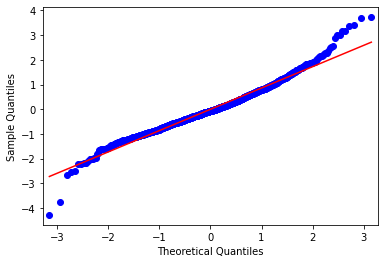

In [236]:
# QQ plot for the AIC model residuals
plt.show(qqplot(model_df['aic_model_residual'], line='s'))

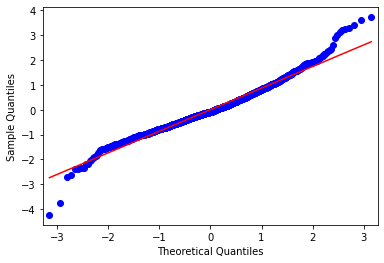

In [237]:
# QQ plot for the BIC model residuals
plt.show(qqplot(model_df['bic_model_residual'], line='s'))

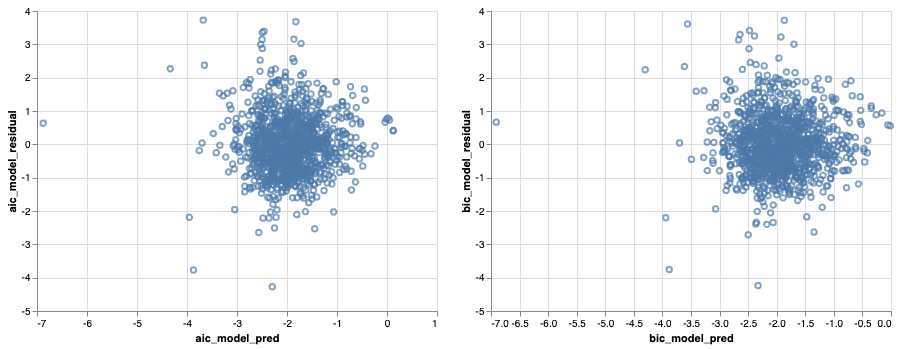

In [238]:
alt.Chart(model_df).mark_point().encode(
    x='aic_model_pred',
    y='aic_model_residual',
) | alt.Chart(model_df).mark_point().encode(
    x='bic_model_pred',
    y='bic_model_residual',
)

> The QQ plots would indicate that our residuals are normal, but their distributions do have slight heavy right tails. I think this would indicate that when the models underestimate, they tend to underestimate more compared to overestimation. The residual plots seem to display no obvious pattern.

## Model interpretation

Next, we will explore the models in depth. As we go through the models, the following sections will be relevant to keep in mind.

- [Boxcox transformation](#Box-Cox-power-transformation) for the relationship between the Boxcox transformed rate and real infection rate

- [Factor interpretation](#Factor-interpretation) for understanding what each factor encompasses in more detail

We will discuss model differences first and then explore what they have in common.

In [239]:
print(aic_res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     infection_rate_50_days_boxcox   R-squared:                       0.305
Model:                                       OLS   Adj. R-squared:                  0.292
Method:                            Least Squares   F-statistic:                     23.59
Date:                           Mon, 18 May 2020   Prob (F-statistic):           4.01e-78
Time:                                   03:14:20   Log-Likelihood:                -1537.1
No. Observations:                           1208   AIC:                             3120.
Df Residuals:                               1185   BIC:                             3238.
Df Model:                                     22                                         
Covariance Type:                       nonrobust                                         
                                                                        coef    std err          t  

> Although this model is less parsimonious, it does provide some useful information regarding the party-specific effects for some factors, which the other model lacks. We will look at the significant ones(< .05 p) here. The poor general well-being(.18) and housing burden(.13) factor scores in blue counties seems to have a moderate effect on the transformed infection rate. The native relative population factor score seems to have exactly opposite effects on the rate between blues(-.10) and reds(.10) counties. The hispanic relative population factor score has surprisingly a negative effect(-.11) on the infection rate for red counties.

In [240]:
print(bic_res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     infection_rate_50_days_boxcox   R-squared:                       0.294
Model:                                       OLS   Adj. R-squared:                  0.284
Method:                            Least Squares   F-statistic:                     29.10
Date:                           Mon, 18 May 2020   Prob (F-statistic):           7.71e-78
Time:                                   03:14:20   Log-Likelihood:                -1546.6
No. Observations:                           1208   AIC:                             3129.
Df Residuals:                               1190   BIC:                             3221.
Df Model:                                     17                                         
Covariance Type:                       nonrobust                                         
                                                              coef    std err          t      P>|t| 

> This model is a lot simpler with less interaction terms. Let's look at the differing significant coefficients. The poor general well-being, the housing burden, and the black relative population factor scores are simplified to have an overall positive effect(.13, .095 & .12) on the transformed infection rate. On the other hand, the hispanic relative factor score is generalized to have a slight negative effect(-.086) on the infection rate.

The two models agree on a lot as well. Both have landed on a relatively substantial positive coefficient(.31) for the inverse suicide factor score as well as a relatively more negative coefficient(-.18) for the crime risk factor score. For the smaller effects, both identify the poor food environment(.036), black relative population(.12), care provider accessibility(-0.11), and population density(.083) factor scores. For insignificant factors, both include the population youth and uninsured rate factor scores. In terms of party differences, both identify the overall income(.33 & -.20) and the urbanization(.31 & -.13) factor scores to have the opposite effects on blue and red counties respectively in terms of their transformed infection rate.

# Final remarks

I want to touch on some limitations of my analysis. First, I am not a domain expert. As a result, there is probably a lot of room for improvement throughout the analysis that would make more sense domain-wise. For instance, there might be a more reasonable response variable given our data. Another example would be the factor analysis. I am confident that a domain expert would likely have more domain-specific insights for the factors, translating to a more robust model interpretation.

Where assumptions or simplifications were made, I have erred on the side of caution. For instance, in my model interpretation, I was merely describing the coefficients without going into detail about what they imply for the general public. However, I think a more thorough investigation of the model would prove to be extremely valuable.

I want to thank the New York Times and County Health Rankings for the data. Thank you for reading. Stay safe!

Trying GLM GAMMA anyway

In [241]:
formula = """
    infection_rate_50_days ~ poor_general_wellbeing_fa_score + 
    housing_burden_fa_score + hispanic_relative_population_fa_score + 
    inverse_sucicde_rate_fa_score + uninsured_rate_fa_score + care_provider_accessibility_fa_score + 
    population_youth_fa_score + crime_risk_fa_score + overall_income_fa_score*state_governor_party + 
    population_density_fa_score + native_relative_population_fa_score + black_relative_population_fa_score + 
    urbanization_level_fa_score*state_governor_party + poor_food_environment_fa_score
"""

In [242]:
import statsmodels.api as sm

gamma_model = smf.glm(formula=formula, data=county, family=sm.families.Gamma()).fit()
print(gamma_model.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     infection_rate_50_days   No. Observations:                 1208
Model:                                GLM   Df Residuals:                     1190
Model Family:                       Gamma   Df Model:                           17
Link Function:              inverse_power   Scale:                          2.9570
Method:                              IRLS   Log-Likelihood:                 86.251
Date:                    Mon, 18 May 2020   Deviance:                       2152.0
Time:                            03:14:20   Pearson chi2:                 3.52e+03
No. Iterations:                        12                                         
Covariance Type:                nonrobust                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [243]:
print(bic_res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     infection_rate_50_days_boxcox   R-squared:                       0.294
Model:                                       OLS   Adj. R-squared:                  0.284
Method:                            Least Squares   F-statistic:                     29.10
Date:                           Mon, 18 May 2020   Prob (F-statistic):           7.71e-78
Time:                                   03:14:20   Log-Likelihood:                -1546.6
No. Observations:                           1208   AIC:                             3129.
Df Residuals:                               1190   BIC:                             3221.
Df Model:                                     17                                         
Covariance Type:                       nonrobust                                         
                                                              coef    std err          t      P>|t| 